# Extract embeddings, PCA

May need to restart kernel for each dataset if worker error

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
import pandas as pd

# import my_custom_dataset_eval from 
import sys
sys.path.append('/home/ben/reef-audio-representation-learning/code/simclr-pytorch-reefs/evaluation/')
from my_custom_dataset_eval import CTDataset_test

In [2]:
starting_weights = "/home/ben/reef-audio-representation-learning/code/simclr-pytorch-reefs/logs/exman-train.py/runs/baseline/checkpoint-5100.pth.tar"

cfg = {'starting_weights': starting_weights, 'finetune': False,
       'data_path': '/mnt/ssd-cluster/ben/data/full_dataset/', 
       'json_path': '/home/ben/reef-audio-representation-learning/data/dataset.json',
       'test_dataset': 'test_bermuda',#######################
       'num_classes': 7, #####################
       'num_workers':4} 

### Load model

In [3]:

class CustomResNet50(nn.Module):

    def __init__(self, num_classes):
        '''
            Constructor of the model. Here, we initialize the model's
            architecture (layers).
        '''
        super(CustomResNet50, self).__init__()

        self.feature_extractor = resnet.resnet50(pretrained=True)       # "pretrained": use weights pre-trained on ImageNet

        # replace the very last layer from the original, 1000-class output
        # ImageNet to a new one that outputs num_classes
        last_layer = self.feature_extractor.fc                          # tip: print(self.feature_extractor) to get info on how model is set up
        in_features = last_layer.in_features                            # number of input dimensions to last (classifier) layer
        self.feature_extractor.fc = nn.Identity()                       # discard last layer...

        self.classifier = nn.Linear(in_features, num_classes)           # ...and create a new one
    

    def forward(self, x):
        '''
            Forward pass. Here, we define how to apply our model. It's basically
            applying our modified ResNet-18 on the input tensor ("x") and then
            apply the final classifier layer on the ResNet-18 output to get our
            num_classes prediction.
        '''
        # x.size(): [B x 3 x W x H]
        features = self.feature_extractor(x)    # features.size(): [B x 512 x W x H]
        prediction = self.classifier(features)  # prediction.size(): [B x num_classes]

        return prediction

# Your function to load pretrained weights
def load_pretrained_weights(cfg, model):
    #custom_weights = cfg['starting_weights']
    #state = torch.load(open(custom_weights, 'rb'), map_location='cpu')

    # This is the line that means its gonna be ImageNet weights!
    pretrained_dict = state['model']

    model_dict = model.state_dict()
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and k not in ['classifier.weight', 'classifier.bias']}
    log = model.load_state_dict(pretrained_dict, strict=False)
    assert log.missing_keys == ['classifier.weight', 'classifier.bias']
    return model

In [4]:
from torchvision.models import resnet

In [5]:
# Initialize your model
model_instance = CustomResNet50(cfg['num_classes'])

# Load the pretrained weights
#model_instance = load_pretrained_weights(cfg, model_instance)

/home/ben/miniconda3/envs/simclr_pytorch_reefs/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ben/miniconda3/envs/simclr_pytorch_reefs/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Dataloader

In [6]:
split = 'test_data'
transform = False
train_percent = 0.0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#dataset = CTDataset_train(cfg, split=split, transform=transform, train_percent=train_percent)
dataset_instance = CTDataset_test(cfg, split=split, transform=transform, train_percent=train_percent)

In [7]:
def get_dataloader(cfg, split, transform, train_percent, batch_size, shuffle, num_workers):
    
    dataset = CTDataset_test(cfg, split, transform, train_percent)

    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle
    )

    return dataloader

sample_loader = get_dataloader(cfg, split, transform=False, train_percent = train_percent, batch_size=64, shuffle=False, num_workers=cfg['num_workers']) 


Does the below cell error? May need to restart kernel

### Extract embeddings

In [8]:
def extract_multiple_embeddings(model, dataloader, device):
    model.eval()
    model.to(device)  # move to GPU
    all_embeddings = []
    labels = []
    
    with torch.no_grad():
        for i, (audio, classes) in enumerate(dataloader):
            audio = audio.to(device)  # move to GPU
            # The following line is changed to use feature_extractor
            embeddings = model.feature_extractor(audio)  
            all_embeddings.extend(embeddings.cpu().numpy())
            labels.extend(classes.cpu().numpy())
            
    return all_embeddings, labels

embeddings, labels = extract_multiple_embeddings(model_instance, sample_loader, device)


### Save the embeddings

In [9]:
# Assuming embeddings is your list of lists, each of 2048 features
# And labels is your list of labels

# Create a DataFrame
df = pd.DataFrame(embeddings, columns=[f'Feature_{i+1}' for i in range(2048)])

# Insert labels as the first column
df.insert(0, 'Label', labels)

# Save the DataFrame to CSV
df.to_csv('raw_embeddings/' + 'ImageNet-' + cfg['test_dataset'][5:] + '-embeddings.csv', index=False)

### PCA plot

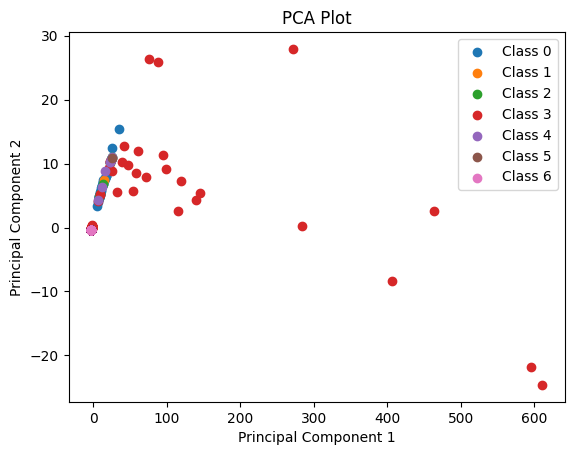

In [10]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Convert embeddings to a NumPy array for easier manipulation
embeddings = np.array(embeddings)

# Initialize PCA and the X vector for dimensionality reduction
pca = PCA(n_components=2)

# Fit and transform the embeddings to get new 2D representations
embeddings_pca = pca.fit_transform(embeddings)

# Create a scatter plot
classes = np.unique(labels)  # Extract unique labels to identify distinct classes
for class_label in classes:
    idx = np.where(np.array(labels) == class_label)  # Get index where class label is found
    plt.scatter(embeddings_pca[idx, 0], embeddings_pca[idx, 1], label=f"Class {class_label}")

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(loc="upper right")
plt.title("PCA Plot")
plt.show()